#### If you are not using google colab ignore the cell bellow

In [0]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!ls 'drive/My Drive/Colab Notebooks/IEEE-CIS/ieee-fraud-detection'

base_path = 'drive/My Drive/Colab Notebooks/IEEE-CIS/ieee-fraud-detection'

final_data.csv	train_identity.csv  train_transaction.csv


In [0]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split

In [0]:
df = pd.read_csv(base_path + "/final_data.csv").drop("TransactionID", axis=1)

print(df.shape)
df.head()

(590540, 502)


,isFraud,TransactionDT,TransactionAmt,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D8,D9,D10,D11,D12,D13,D14,D15,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,id_28-None,id_29-Found,id_29-None,id_29-NotFound,id_30-Android,id_30-Linux,id_30-Mac-OS,id_30-None,id_30-Windows,id_30-iOS,id_30-other,id_31-None,id_31-chrome,id_31-chrome-for-android,id_31-chrome-for-ios,id_31-edge,id_31-firefox,id_31-ie-for-desktop,id_31-ie-for-tablet,id_31-opera,id_31-other,id_31-safari,id_31-samsung,id_34-None,id_34-match_status:-1,id_34-match_status:0,id_34-match_status:1,id_34-match_status:2,id_35-F,id_35-None,id_35-T,id_36-F,id_36-None,id_36-T,id_37-F,id_37-None,id_37-T,id_38-F,id_38-None,id_38-T
0,0,86400,68.5,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,169.563231,13.000000,140.002441,42.335965,69.805717,146.058108,0.561057,13.000000,13.000000,54.037533,17.901295,57.724444,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,...,0.022568,0.519479,0.022568,0.457953,0.0437,0.007876,0.092052,0.462224,0.25472,0.137153,0.002274,0.027393,0.378783,0.14462,0.003931,0.043977,0.043943,0.062607,0.004486,0.003113,0.019704,0.253382,0.014061,0.46056,0.000021,0.002877,0.120472,0.41607,0.437979,0.022519,0.539502,0.92951,0.022519,0.047971,0.211692,0.022519,0.765789,0.512518,0.022519,0.464963
1,0,86401,29.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,169.563231,28.343348,0.000000,42.335965,69.805717,146.058108,0.561057,0.000000,146.621465,54.037533,17.901295,57.724444,0.000000,0.999945,1.045204,1.078075,0.846456,0.876991,1.045686,1.07287,1.027704,1.041529,...,0.022568,0.519479,0.022568,0.457953,0.0437,0.007876,0.092052,0.462224,0.25472,0.137153,0.002274,0.027393,0.378783,0.14462,0.003931,0.043977,0.043943,0.062607,0.004486,0.003113,0.019704,0.253382,0.014061,0.46056,0.000021,0.002877,0.120472,0.41607,0.437979,0.022519,0.539502,0.92951,0.022519,0.047971,0.211692,0.022519,0.765789,0.512518,0.022519,0.464963
2,0,86469,59.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,169.563231,28.343348,0.000000,42.335965,69.805717,146.058108,0.561057,0.000000,315.000000,54.037533,17.901295,57.724444,315.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,...,0.022568,0.519479,0.022568,0.457953,0.0437,0.007876,0.092052,0.462224,0.25472,0.137153,0.002274,0.027393,0.378783,0.14462,0.003931,0.043977,0.043943,0.062607,0.004486,0.003113,0.019704,0.253382,0.014061,0.46056,0.000021,0.002877,0.120472,0.41607,0.437979,0.022519,0.539502,0.92951,0.022519,0.047971,0.211692,0.022519,0.765789,0.512518,0.022519,0.464963
3,0,86499,50.0,2.0,5.0,0.0,0.0,0.0,4.0,0.0,0.0,1.0,0.0,1.0,0.0,25.0,1.0,112.0,112.000000,0.000000,94.000000,0.000000,69.805717,146.058108,0.561057,84.000000,146.621465,54.037533,17.901295,57.724444,111.000000,0.999945,1.045204,1.078075,0.846456,0.876991,1.045686,1.07287,1.027704,1.041529,...,0.022568,0.519479,0.022568,0.457953,0.0437,0.007876,0.092052,0.462224,0.25472,0.137153,0.002274,0.027393,0.378783,0.14462,0.003931,0.043977,0.043943,0.062607,0.004486,0.003113,0.019704,0.253382,0.014061,0.46056,0.000021,0.002877,0.120472,0.41607,0.437979,0.022519,0.539502,0.92951,0.022519,0.047971,0.211692,0.022519,0.765789,0.512518,0.022519,0.464963
4,0,86506,50.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,169.563231,28.343348,140.002441,42.335965,69.805717,146.058108,0.561057,123.982137,146.621465,54.037533,17.901295,57.724444,163.744579,0.999945,1.045204,1.078075,0.846456,0.876991,1.045686,1.07287,1.027704,1.041529,...,0.000000,0.000000,0.000000,1.000000,1.0000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.00000,0.000000,0.000000,0.000000,1.00000,0.000000,0.000000,1.000000,1.00000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000


##  Up sampling

In [0]:
df_fraud = df[df.isFraud == 1]
n_fraud = df_fraud.shape[0]
df_non_fraud = df[df.isFraud == 0].sample(frac=0.5)
n_non_fraud = df_non_fraud.shape[0]

print(n_fraud)
print(df.shape[0])
print(int(n_non_fraud / n_fraud))

replicated_fraud = pd.concat([df_fraud for _ in range(int(n_non_fraud / n_fraud)+1)])
print(replicated_fraud.shape)

del df_fraud

df_augumentated = pd.concat([replicated_fraud, df_non_fraud]).sample(frac=1.)

del replicated_fraud
del df_non_fraud

y = df_augumentated.isFraud.values
X = df_augumentated.drop("isFraud", axis=1).values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

del df_augumentated
del df

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

20663
590540
13
(289282, 502)
(401954, 501)
(172266, 501)
(401954,)
(172266,)


## under sampling

In [0]:
 

# n_fraud = df[df.isFraud == 1].shape[0]
# df_fraud = df[df.isFraud == 1]
# df_non_fraud = df[df.isFraud == 0].sample(n=n_fraud)
# df_sample = pd.concat([df_fraud, df_non_fraud]).sample(frac=1.0)

# y = df_sample.isFraud.values
# X = df_sample.drop("isFraud", axis=1).values

# X_train, X_test, y_train,  y_test = train_test_split(X, y, test_size=0.3)

# del df_sample

# print(X_train.shape)
# print(X_test.shape)
# print(y_train.shape)
# print(y_test.shape)

In [0]:
#verifying the whether the datset is balanced
print(y_train[y_train == 1].shape[0]/y_train.shape[0])
print(y_train[y_train == 0].shape[0]/y_train.shape[0])
print()
print(y_test[y_test == 1].shape[0]/y_test.shape[0])
print(y_test[y_test == 0].shape[0]/y_test.shape[0])

0.5033784960468113
0.49662150395318866

0.5047252504847155
0.4952747495152845


In [0]:
gbm = xgb.XGBClassifier(base_score=0.5, booster='gbtree', 
               gamma=0, learning_rate=0.01, max_delta_step=0, max_depth=12,
              min_child_weight=1, missing=None, n_estimators=300, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=0.01, scale_pos_weight=1, seed=None,
              subsample=1,  verbosity=1)

gbm


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.01, max_delta_step=0, max_depth=12,
              min_child_weight=1, missing=None, n_estimators=300, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=0.01, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [0]:
import time

t = time.time()
gbm.fit(X_train, y_train)

print("{} seconds elapsed".format(time.time() - t))

6063.394356966019 seconds elapsed


In [0]:
6063/60

101.05

In [0]:
y_pred = gbm.predict(X_test)
y_score = gbm.predict_proba(X_test)

In [0]:
y_pred

array([0, 1, 1, ..., 0, 1, 0])

In [0]:
from sklearn.metrics import classification_report

target_names = ['Non-Fraud', 'Fraud']

print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

   Non-Fraud       0.89      0.93      0.91     85319
       Fraud       0.93      0.88      0.91     86947

    accuracy                           0.91    172266
   macro avg       0.91      0.91      0.91    172266
weighted avg       0.91      0.91      0.91    172266



In [0]:
# kappa score
from sklearn.metrics import cohen_kappa_score
kappa = cohen_kappa_score(y_test, y_pred)
print("ohen kappa: {}".format(kappa))

ohen kappa: 0.8135472983661869


# Computing the confusion Matrix

Automatically created module for IPython interactive environment
Confusion matrix, without normalization
Normalized confusion matrix


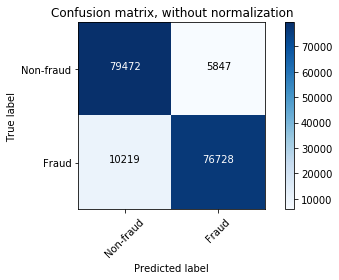

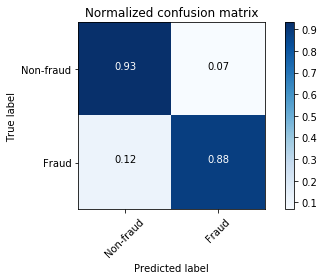

In [0]:
print(__doc__)

import itertools
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')


    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

    
class_names = ["Non-fraud", "Fraud"]

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

# Ploting the ROC CURVE
Considering a binary classification

Automatically created module for IPython interactive environment


Using TensorFlow backend.


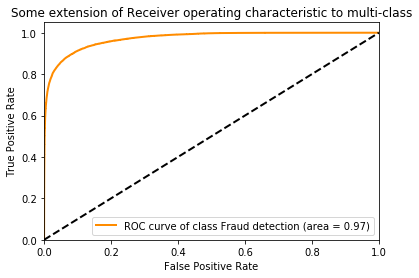

In [0]:
print(__doc__)

import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from keras.utils import to_categorical

fpr, tpr, _ = roc_curve(y_test, y_score[:,1])
roc_auc = auc(fpr, tpr)

# Plot all ROC curves
class_name = ['Down', 'Up', 'Neither']
colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])

color = 'darkorange'
plt.plot(fpr, tpr, color=color, lw=2,
         label='ROC curve of class {0} (area = {1:0.2f})'
         ''.format("Fraud detection", roc_auc))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()